In [4]:
%matplotlib ipympl

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import matplotlib.patheffects as pe

import networkx as nx
import matplotlib.patches as mpatches

from learning.model.stateflow import DWStateFlowModel
from learning.data.load_utils import adj_matrix_to_edges, extract_nodes_states
from learning.data.stateflow_utils import get_active_edges_mask, collate_stateflow_data
from matplotlib.colors import LinearSegmentedColormap
from learning.data.stateflow_dataset import DWStateFlowDataset
import torch
from learning.data.load_utils import load_dicewars_data


In [5]:
stateflow_model = DWStateFlowModel()

models_dir = "learning/stateflow_checkpoints" 

# Find the latest checkpoint file (with highest epoch number)
checkpoint_files = glob.glob(os.path.join(models_dir, "stateflow_*.pt"))

epoch_nums = [int(f.split("_")[-1].split(".")[0]) for f in checkpoint_files]
latest_epoch = max(epoch_nums)
latest_checkpoint = os.path.join(models_dir, f"stateflow_{latest_epoch}.pt")
checkpoint = torch.load(latest_checkpoint, map_location=torch.device("cpu"))
model_state = checkpoint["model_state"]
stateflow_model.load_state_dict(model_state)

print(f"Loading latest checkpoint: {latest_checkpoint} (epoch {latest_epoch})")

Loading latest checkpoint: learning/stateflow_checkpoints/stateflow_417.pt (epoch 417)


In [ ]:
history_folder = "server/history/"

history_files = sorted(glob.glob(os.path.join(history_folder, "history_*.json")))
history_file = history_files[random.randint(0, len(history_files))]
history_data = json.load(open(history_file, "r"))
print(history_file)

TypeError: randint(): argument 'size' (position 2) must be tuple of ints, not int

In [ ]:
graph = nx.from_numpy_array(np.array(history_data["adjacency"]))

In [ ]:
edges = np.array(graph.edges())

In [ ]:
stateflow_model

DWStateFlowModel(
  (norm_fn): DWNorm()
  (gat_layers): ModuleList(
    (0): GATLayer(
      (message_fn): GATMessage(
        (input_dropout): Dropout(p=0, inplace=False)
        (transform_fn): Linear(in_features=8, out_features=8, bias=False)
      )
      (attention_coef_fn): GATAttentionCoefficients(
        (transform_fn): Linear(in_features=16, out_features=1, bias=False)
        (activation_fn): LeakyReLU(negative_slope=0.01)
      )
      (attention_dropout): Dropout(p=0.35, inplace=False)
      (activation_fn): ReLU()
      (residual_proj): Linear(in_features=8, out_features=8, bias=False)
      (residual_dropout): Dropout(p=0.35, inplace=False)
    )
    (1-2): 2 x GATLayer(
      (message_fn): GATMessage(
        (input_dropout): Dropout(p=0.35, inplace=False)
        (transform_fn): Linear(in_features=8, out_features=8, bias=False)
      )
      (attention_coef_fn): GATAttentionCoefficients(
        (transform_fn): Linear(in_features=16, out_features=1, bias=False)
       

In [ ]:
players_color_map = { 
    i: color for i, color in enumerate([
        "#b37ffe",  # purple
        "#b3ff01",  # lime green
        "#009302",  # dark green
        "#ff7ffe",  # pink
        "#ff7f01",  # orange
        "#b3fffe",  # light cyan
        "#ffff01",  # yellow
        "#ff5858"   # light red
    ])    
}

In [ ]:
def draw_prediction(ax, graph, pos, history_data, index, model):
    data = DWStateFlowDataset(json_data=load_dicewars_data(
        json_data=history_data, drop_terminal_state=False))[index]
    in_data = collate_stateflow_data([data])
    inv_reindex = torch.argsort(data["reindex"])
    edges_tn = in_data["all_edges"]
    state_tn = in_data["nodes_states"]
    model.eval()
    with torch.no_grad():
        out = model.forward(
            in_data["nodes_states"], 
            in_data["all_edges"], 
            in_data["node_graph_ids"], 
            in_data["edge_graph_ids"]
        )
    

    out_dict = out[0]
    winner_logit = out_dict["winner_logit"]
    edges_attack_logit = out_dict["edges_attack_logit"]
    end_turn_logit = out_dict["end_turn_logit"]

    action_prob = torch.softmax(torch.cat([edges_attack_logit, end_turn_logit]), dim=-1).numpy()
    winner_prob = torch.softmax(winner_logit, dim=-1)[inv_reindex].numpy()

    end_turn_prob = action_prob[-1]
    any_attack_prob = 1 - end_turn_prob
    attack_prob = action_prob[:-1]

    # Create a custom blue-to-red colormap without white in the middle
    blue_red_cmap = LinearSegmentedColormap.from_list('BlueRed', ['blue', 'yellow', 'red'])
    vmax = action_prob.max()
    vmin = 0

    # title color scale is 0-1 to highlight cases high probability for attack along any edge
    # edges color scale is 0-max_action_p to highlight with red which particular edge of attack is likely to be launched,
    #  if any - as eng of turn probability is included in the action max

    # Set the title with normal black text
    ax.set_title("Next action prediction")
    
    legend_start = (0.01, 0.93)
    patch_size = 0.05
    # Add a colored patch to show the probability visually in the top left
    patch = mpatches.Rectangle(legend_start, patch_size, patch_size, 
                             transform=ax.transAxes,
                             color=blue_red_cmap(any_attack_prob),
                             ec='black')
    ax.add_patch(patch)
    # Add text next to the patch
    print(legend_start[1] + patch_size / 2)
    ax.text(
        legend_start[0] + patch_size + 0.01, legend_start[1] + 0.02,  
        f"attack_p = {any_attack_prob*100:.1f}%", transform=ax.transAxes
    )

    step = 0.07
    for player_i in range(8):
        info_pos = (legend_start[0], legend_start[1] - step * (player_i + 1))
        patch = mpatches.Rectangle(
            info_pos,
            patch_size, patch_size, 
            transform=ax.transAxes,
            color=players_color_map[player_i],
            ec='black'
        )
        ax.add_patch(patch)

        ax.text(
            info_pos[0] + patch_size + 0.01, info_pos[1] + 0.02,
            f"{winner_prob[player_i]*100:.1f}%", transform=ax.transAxes
        )


    active_edges_mask = get_active_edges_mask(state_tn, edges_tn)
    active_edges = edges_tn[:, active_edges_mask].numpy()

    active_player_nodes = torch.where(state_tn[..., 0] > 0)[0]
    border_edges = \
        (torch.isin(edges_tn[0], active_player_nodes) & ~torch.isin(edges_tn[1], active_player_nodes)) \
         | (torch.isin(edges_tn[1], active_player_nodes) & ~torch.isin(edges_tn[0], active_player_nodes))
    
    # no_directed_no_self_edges_mask = edges_tn[0] < edges_tn[1]
    non_active_edges_mask = ~border_edges
    non_active_edges = edges_tn[:, non_active_edges_mask].numpy()
    
    # Use a fixed curvature value for all edges
    nx.draw_networkx_edges(
        graph, pos,
        edgelist=active_edges.T,
        edge_color=attack_prob,
        edge_cmap=blue_red_cmap,
        edge_vmax=vmax,
        edge_vmin=vmin,
        width=2.0,  # Make edges thicker
        arrows=True,  # Add arrows to show direction
        arrowstyle="-|>",  # Use a nice arrow style
        ax=ax
    )
    nx.draw_networkx_edges(
        graph, pos,
        edgelist=non_active_edges.T,
        width=2,
        edge_color="grey",
        ax=ax
    )

    # Add edge labels with probability values (2 decimal places)
    edge_labels = {(u, v): f"{p*100:.0f}" for (u, v), p in zip(active_edges.T, attack_prob)}
    nx.draw_networkx_edge_labels(
        graph, pos,
        edge_labels=edge_labels,
        font_size=8,
        font_color="black",
        font_weight="bold",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=0.1),
        label_pos=0.4,  # Position along the edge
        rotate=False,
        ax=ax
    )


In [ ]:
def draw_state(ax_base, ax_pred, history_data, index):
    if index < len(history_data["actions"]):
        action = history_data["actions"][index]
    else:
        action = {"move_made": False, "turn_end": False, "player": None}

    state = history_data["states"][index]
    teams = np.array(state["teams"])
    dice = np.array(state["dice"])
    node_positions = history_data["node_positions"]

    pos = {
        i: np.array([1, -1]) * np.array(node_pos)
        for i, node_pos in enumerate(node_positions)
    }
    xs, ys = zip(*pos.values())            # list of all x and y after shift
    left_pad  = 7.0                        # blank space on the left
    pad = 3.0                        # default
    ax_base.set_xlim(min(xs) - left_pad,  max(xs) + pad)
    ax_base.set_ylim(min(ys) - pad,  max(ys) + pad)
    ax_pred.set_xlim(min(xs) - left_pad,  max(xs) + pad)
    ax_pred.set_ylim(min(ys) - pad,  max(ys) + pad)

    graph = nx.from_numpy_array(np.array(history_data["adjacency"]))

    # 1) Build unique list and assign colors
    unique_teams = sorted(set(teams))  # preserves order
    cmap = plt.get_cmap("Set3")
    # 8 teams max
    color_map = { 
        i: color for i, color in enumerate([
            "#b37ffe",  # purple
            "#b3ff01",  # lime green
            "#009302",  # dark green
            "#ff7ffe",  # pink
            "#ff7f01",  # orange
            "#b3fffe",  # light cyan
            "#ffff01",  # yellow
            "#ff5858"   # light red
        ])    
    }

    # 2) Draw nodes using that mapping
    node_colors = [ color_map[t] for t in teams ]
    nx.draw_networkx_nodes(
        graph, pos,
        node_size=500,
        node_color=node_colors,
        edgecolors='black',
        ax=ax_base
    )
    nx.draw_networkx_nodes(
        graph, pos,
        node_size=500,
        node_color=node_colors,
        edgecolors='black',
        ax=ax_pred
    )

    # 3) Draw edges & labels
    # ----------------------------------------------------------
    # 3a) draw ALL ordinary edges (no arrows, default styling)
    #     keep the special edge OUT of this list
    # ----------------------------------------------------------
    if action["move_made"]:
        special_edge = (action["from"], action["to"])  # <-- pick the edge (u, v)
        dice_in_attack = dice[action["from"]] - 1
    else:
        special_edge = None

    ordinary_edges = [e for e in graph.edges() if e != special_edge]

    nx.draw_networkx_edges(
        graph, pos,
        edgelist=ordinary_edges,
        width=2,
        edge_color="grey",
        ax=ax_base
    )

    if action["move_made"]:
        # ----------------------------------------------------------
        # 3b) draw THAT ONE edge again, but with a styled ARROW
        # ----------------------------------------------------------
        nx.draw_networkx_edges(
            graph, pos,
            edgelist=[special_edge],
            width=3,
            edge_color="darkblue",
            arrows=True,                 # activate arrowheads
            arrowstyle="-|>",            # filled triangular head
            arrowsize=10,                # head size (points)
            ax=ax_base
        )

        # ----------------------------------------------------------
        # 3c) add a text label on (or near) that edge
        # ----------------------------------------------------------
        edge_lbl = {special_edge: dice_in_attack}   # label text - number of dice used in attack
        nx.draw_networkx_edge_labels(
            graph, pos,
            edge_labels=edge_lbl,
            font_color="darkblue",
            font_weight="bold",
            font_size=11,
            label_pos=0.35,              # 0 = src node, 1 = dst node
            bbox=dict(facecolor="white", edgecolor="none", pad=0.1),
            ax=ax_base,
            rotate=False
        )


    # ----------------------------------------------------------
    # 3d) create node labels
    # ----------------------------------------------------------
    label_dict = { i: d for i, d in enumerate(dice) }
    nx.draw_networkx_labels(
        graph, pos,
        labels=label_dict,
        font_size=12,
        font_weight='bold',
        ax=ax_base
    )

    # 4) Build and add legend
    legend_handles = [
        mpatches.Patch(
            facecolor=color_map[team], label=str(team), 
            edgecolor="black", linewidth=1
        )
        for team in unique_teams
    ]
    ax_base.legend(
        handles=legend_handles,
        title="Player",
        loc='upper left',      # Position the legend at the upper left
    )

    # 5) Add action description title
    title = f"State #{index} / {len(history_data['states']) - 1}"
    title += f"\nPlayer {action['player']}"

    if action["move_made"]:
        title = title \
            + f" attacked" \
            + f" from node {special_edge[0]} to {special_edge[1]}" \
            + f" with {dice_in_attack} dice"
    if action["turn_end"]:
        title += " ended the turn"

    ax_base.set_title(title, fontsize=16)

    # 6) Finalize
    #ax_base.axis('off')
    #ax_pred.axis('off')
    ax_base.format_coord = lambda x, y: ""      # suppress the live x-, y-readout
    ax_pred.format_coord = lambda x, y: ""     

    draw_prediction(ax_pred, graph, pos, history_data, index, stateflow_model)

0.9550000000000001


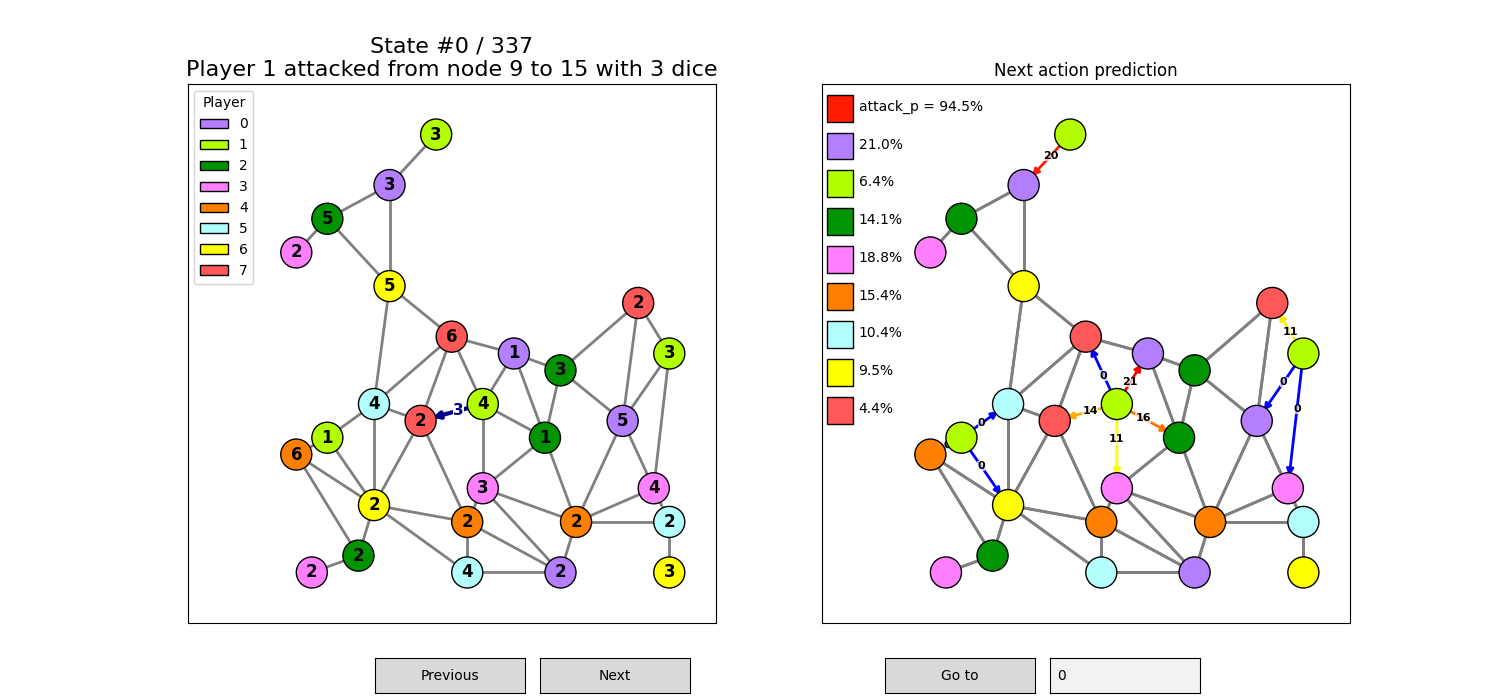

IndexError: index 337 is out of bounds for dimension 0 with size 337

IndexError: index 337 is out of bounds for dimension 0 with size 337

In [ ]:
from matplotlib.widgets import Button
from matplotlib.widgets import Button, TextBox

plt.close('all')

# --- your existing setup ---
f, [real_ax, predicted_ax] = plt.subplots(1, 2, figsize=(15,7))

n_states = len(history_data["states"])
# Initialize with the first state
current_idx = 0
max_idx = len(history_data["states"]) - 1

# Function to update the plot
def update_plot(idx):
    real_ax.clear()
    predicted_ax.clear()
    draw_state(real_ax, predicted_ax, history_data, idx)
    text_box.set_val(str(idx))
    plt.draw()

# Initial plot
draw_state(real_ax, predicted_ax, history_data, current_idx)

# Add buttons for navigation and text input
prev_ax = plt.axes([0.25, 0.01, 0.1, 0.05])
next_ax = plt.axes([0.36, 0.01, 0.1, 0.05])  # Centered next button
go_ax = plt.axes([0.59, 0.01, 0.1, 0.05])
text_ax = plt.axes([0.7, 0.01, 0.1, 0.05])


# Create the text input for state index
text_box = TextBox(text_ax, label="", initial=str(current_idx))

# Go button handler
def go_click(event):
    global current_idx
    try:
        idx = int(text_box.text)
        # If the index is out of bounds, clamp it to valid range
        if idx < 0:
            current_idx = 0
        elif idx > max_idx:
            current_idx = max_idx
        else:
            current_idx = idx
    except ValueError:
        current_idx = 0

    text_box.set_val(str(current_idx))
    update_plot(current_idx)

go_button = Button(go_ax, 'Go to')
go_button.on_clicked(go_click)
prev_button = Button(prev_ax, 'Previous')
next_button = Button(next_ax, 'Next')

# Button click handlers
def prev_click(event):
    global current_idx
    current_idx = max(0, current_idx - 1)
    update_plot(current_idx)

def next_click(event):
    global current_idx
    current_idx = min(max_idx, current_idx + 1)
    update_plot(current_idx)

prev_button.on_clicked(prev_click)
next_button.on_clicked(next_click)

plt.show()

In [ ]:
torch.exp(torch.tensor([-1.2253178358078003,0.7169307470321655]))

tensor([0.2937, 2.0481])

In [ ]:
torch.sigmoid(torch.tensor(6))

tensor(0.9975)